In [2]:
import numpy as np
import pandas as pd
from spec_id import Likelihood_contours, Median_w_Error,Median_w_Error_cont, Gen_spec
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [3]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [20]:
galDB

,gids,ids,ra,dec,hi_res_specz,Z,Z_-_sig,Z_+_sig,t,t_-_sig,t_+_sig,lmass,tau
43,n14713,14713,189.236333,62.214608,1.232,0.019,0.012,0.008,3.1,0.903,0.541,10.56,8.78
49,n16758,16758,189.162357,62.224840,1.014,0.021,0.002,0.002,5.5,0.470,0.125,10.83,0.00
50,n17070,17070,189.268086,62.226445,1.192,0.017,0.007,0.006,2.5,0.732,0.998,10.92,8.60
58,n19442,19442,189.123036,62.237460,1.101,0.015,0.010,0.010,2.9,1.033,0.818,10.10,8.85
61,n21156,21156,189.239409,62.247548,1.251,0.015,0.005,0.006,2.6,0.524,0.622,11.16,8.30
62,n21427,21427,189.368121,62.247344,1.514,0.020,0.009,0.007,2.8,0.779,0.533,10.73,8.60
69,n23435,23435,189.338306,62.256571,1.134,0.015,0.007,0.008,3.7,0.907,0.779,10.27,8.60
86,n32566,32566,189.161280,62.307577,1.150,0.020,0.008,0.007,2.7,1.054,0.919,10.61,8.70
96,n34694,34694,189.147840,62.323647,1.145,0.014,0.005,0.006,3.1,0.671,1.048,10.94,8.48
107,n37686,37686,189.274474,62.360820,1.258,0.016,0.003,0.003,3.6,0.598,0.548,10.89,8.60


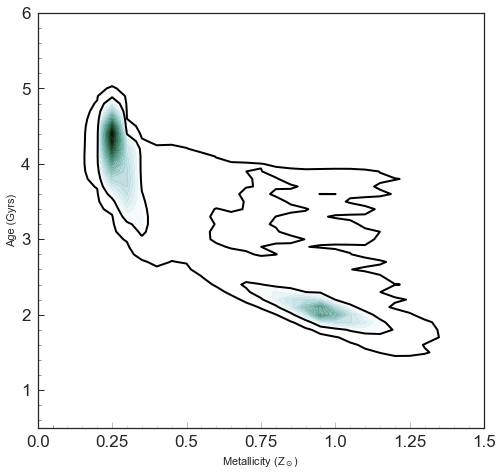

(0.0090000000000000000002, 0.0039999999999999999998, 0.011)
(3.5, 1.446, 0.80300000000000000002)


In [14]:
% matplotlib inline

Pr = np.load('../chidat/s35774_tZ_pos.npy')

onesig,twosig=Likelihood_contours(age,metal,Pr)
levels=np.array([twosig,onesig])

plt.figure(figsize=[8,8])
plt.contour(M,A,Pr,levels,colors='k',linewidths=2)
plt.contourf(M,A,Pr,40,cmap=colmap, alpha=.7)
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.tick_params(axis='both', which='major', labelsize=17)
plt.gcf().subplots_adjust(bottom=0.16)
plt.minorticks_on()
plt.xlabel('Metallicity (Z$_\odot$)')
plt.ylabel('Age (Gyrs)')
plt.legend()
plt.show()
plt.close()

Z,PZ = np.load('../chidat/s35774_Z_pos.npy')
t,Pt = np.load('../chidat/s35774_t_pos.npy')

print Median_w_Error(PZ,Z)

print Median_w_Error(Pt,t)


# plt.figure(figsize=[8,8])
# plt.plot(Z,PZ)
# plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
# plt.xlabel('Metallicity (Z$_\odot$)')
# plt.show()
# plt.close()
# 
# plt.figure(figsize=[8,8])
# plt.plot(t,Pt)
# plt.xlabel('Age (Gyrs)')
# plt.show()
# plt.close()

In [19]:
galDB['Z'][212] = 0.009
galDB['Z_-_sig'][212] =0.004
galDB['Z_+_sig'][212] = 0.011
galDB['t'][212] = 3.5 
galDB['t_-_sig'][212] = 1.446
galDB['t_+_sig'][212] = 0.803

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  a

In [21]:
for i in galDB.index:
    Pr = np.load('../chidat/%s_tZ_pos.npy' % galDB['gids'][i])

    onesig,twosig=Likelihood_contours(age,metal,Pr)
    levels=np.array([twosig,onesig])
    
    plt.figure(figsize=[8,8])
    plt.contour(M,A,Pr,levels,colors='k',linewidths=2)
    plt.contourf(M,A,Pr,40,cmap=colmap, alpha=.7)
    plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.gcf().subplots_adjust(bottom=0.16)
    plt.minorticks_on()
    plt.title(galDB['gids'][i])
    plt.xlabel('Metallicity (Z$_\odot$)')
    plt.ylabel('Age (Gyrs)')
    plt.legend()
    # plt.show()
    plt.savefig('../plots/LHS/%s_LH.png' % galDB['gids'][i])
    plt.close()

In [35]:
med = np.zeros(len(galDB.index))
lerr = np.zeros(len(galDB.index))
herr = np.zeros(len(galDB.index))


for i in range(len(galDB.index)):
    t, Pt = np.load('../chidat/%s_t_pos.npy' % galDB['gids'][galDB.index[i]])
    med[i],lerr[i],herr[i] = Median_w_Error(Pt,t)

In [46]:
galDB['t_+_sig'] = herr

In [48]:
galDB

,gids,ids,ra,dec,hi_res_specz,Z,Z_-_sig,Z_+_sig,t,t_-_sig,t_+_sig
43,n14713,14713,189.236333,62.214608,1.232,0.019,0.012,0.008,3.1,0.903,0.541
49,n16758,16758,189.162357,62.224840,1.014,0.021,0.002,0.002,5.5,0.470,0.125
50,n17070,17070,189.268086,62.226445,1.192,0.017,0.007,0.006,2.5,0.732,0.998
58,n19442,19442,189.123036,62.237460,1.101,0.015,0.010,0.010,2.9,1.033,0.818
61,n21156,21156,189.239409,62.247548,1.251,0.015,0.005,0.006,2.6,0.524,0.622
62,n21427,21427,189.368121,62.247344,1.514,0.020,0.009,0.007,2.8,0.779,0.533
69,n23435,23435,189.338306,62.256571,1.134,0.015,0.007,0.008,3.7,0.907,0.779
86,n32566,32566,189.161280,62.307577,1.150,0.020,0.008,0.007,2.7,1.054,0.919
96,n34694,34694,189.147840,62.323647,1.145,0.014,0.005,0.006,3.1,0.671,1.048
107,n37686,37686,189.274474,62.360820,1.258,0.016,0.003,0.003,3.6,0.598,0.548


In [19]:
pd.to_pickle(galDB,'../data/sgal_param_DB.pkl')

In [8]:
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

In [13]:
mzDB

,gids,ids,ra,dec,hi_res_specz,Z,Z_-_sig,Z_+_sig,t,t_-_sig,t_+_sig,lmass,tau
50,n17070,17070,189.268086,62.226445,1.192,0.017,0.007,0.006,2.5,0.732,0.998,10.92,8.60
61,n21156,21156,189.239409,62.247548,1.251,0.015,0.005,0.006,2.6,0.524,0.622,11.16,8.30
107,n37686,37686,189.274474,62.360820,1.258,0.016,0.003,0.003,3.6,0.598,0.548,10.89,8.60
212,s35774,35774,53.158775,-27.742385,1.223,0.009,0.004,0.011,3.5,1.446,0.803,10.86,8.60
217,s38785,38785,53.168249,-27.727300,1.175,0.014,0.009,0.008,3.3,1.081,0.738,10.88,8.78
225,s39805,39805,53.163237,-27.724724,1.242,0.022,0.011,0.006,2.9,0.967,0.554,10.62,8.78
228,s40476,40476,53.108262,-27.721924,1.212,0.007,0.003,0.006,2.9,0.769,0.675,10.59,8.60
230,s40597,40597,53.148451,-27.719472,1.221,0.026,0.006,0.003,3.6,0.477,0.174,11.01,8.90


In [10]:
%matplotlib inline
Pl,Pm,Ph,Puh = np.ones([4,len(metal)])

for i in lzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % lzDB['gids'][i])
    Pl = Pl * PZ
    
for i in mzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % mzDB['gids'][i])
    Pm = Pm * PZ
    
for i in hzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % hzDB['gids'][i])
    Ph = Ph * PZ
    
for i in uhzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % uhzDB['gids'][i])
    Puh = Puh * PZ
    
Pl /= np.trapz(Pl,metal)
Pm /= np.trapz(Pm,metal)
Ph /= np.trapz(Ph,metal)
Puh /= np.trapz(Puh,metal)

Pl8,Pm8,Ph8,Puh8 = np.ones([4,len(metal)])

for i in lzDB.index:
    Z,PZ = np.load('../chidat/%s_80-114_Z_pos.npy' % lzDB['gids'][i])
    Pl8 = Pl8 * PZ
    
for i in mzDB.index:
    Z,PZ = np.load('../chidat/%s_80-114_Z_pos.npy' % mzDB['gids'][i])
    Pm8 = Pm8 * PZ
    
for i in hzDB.index:
    Z,PZ = np.load('../chidat/%s_80-114_Z_pos.npy' % hzDB['gids'][i])
    Ph8 = Ph8 * PZ
    
for i in uhzDB.index:
    Z,PZ = np.load('../chidat/%s_80-114_Z_pos.npy' % uhzDB['gids'][i])
    Puh8 = Puh8 * PZ
    
Pl8 /= np.trapz(Pl8,metal)
Pm8 /= np.trapz(Pm8,metal)
Ph8 /= np.trapz(Ph8,metal)
Puh8 /= np.trapz(Puh8,metal)

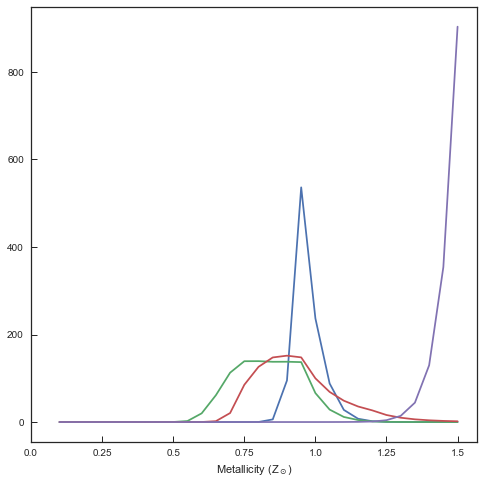

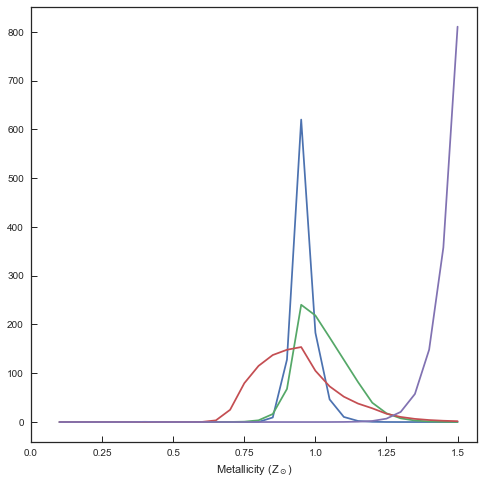

In [11]:
plt.figure(figsize=[8,8])
plt.plot(metal,Pl)
plt.plot(metal,Pm)
plt.plot(metal,Ph)
plt.plot(metal,Puh)
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.xlabel('Metallicity (Z$_\odot$)')
plt.show()
plt.close()

plt.figure(figsize=[8,8])
plt.plot(metal,Pl8)
plt.plot(metal,Pm8)
plt.plot(metal,Ph8)
plt.plot(metal,Puh8)
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.xlabel('Metallicity (Z$_\odot$)')
plt.show()
plt.close()

In [12]:
%matplotlib inline
Pl,Pm,Ph,Puh = np.ones([4,len(age)])

for i in lzDB.index:
    t,Pt = np.load('../chidat/%s_t_pos.npy' % lzDB['gids'][i])
    Pl = Pl * Pt
    
for i in mzDB.index:
    t,Pt = np.load('../chidat/%s_t_pos.npy' % mzDB['gids'][i])
    Pm = Pm * Pt
    
for i in hzDB.index:
    t,Pt = np.load('../chidat/%s_t_pos.npy' % hzDB['gids'][i])
    Ph = Ph * Pt
    
for i in uhzDB.index:
    t,Pt = np.load('../chidat/%s_t_pos.npy' % uhzDB['gids'][i])
    Puh = Puh * Pt
    
Pl /= np.trapz(Pl,age)
Pm /= np.trapz(Pm,age)
Ph /= np.trapz(Ph,age)
Puh /= np.trapz(Puh,age)

Pl8,Pm8,Ph8,Puh8 = np.ones([4,len(age)])

for i in lzDB.index:
    Z,PZ = np.load('../chidat/%s_80-114_t_pos.npy' % lzDB['gids'][i])
    Pl8 = Pl8 * PZ
    
for i in mzDB.index:
    Z,PZ = np.load('../chidat/%s_80-114_t_pos.npy' % mzDB['gids'][i])
    Pm8 = Pm8 * PZ
    
for i in hzDB.index:
    Z,PZ = np.load('../chidat/%s_80-114_t_pos.npy' % hzDB['gids'][i])
    Ph8 = Ph8 * PZ
    
for i in uhzDB.index:
    Z,PZ = np.load('../chidat/%s_80-114_t_pos.npy' % uhzDB['gids'][i])
    Puh8 = Puh8 * PZ
    
Pl8 /= np.trapz(Pl8,age)
Pm8 /= np.trapz(Pm8,age)
Ph8 /= np.trapz(Ph8,age)
Puh8 /= np.trapz(Puh8,age)

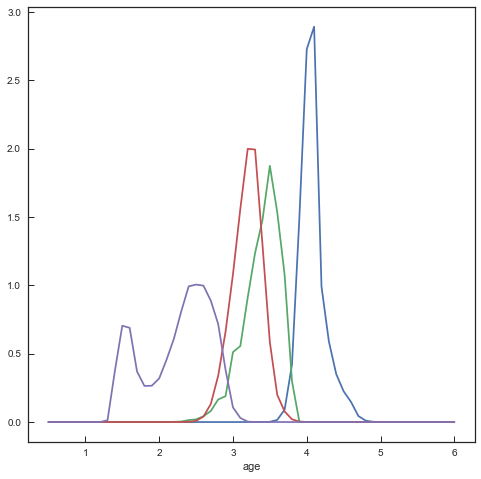

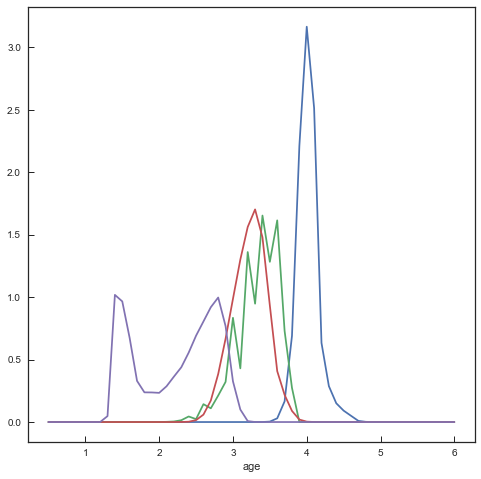

In [13]:
plt.figure(figsize=[8,8])
plt.plot(age,Pl)
plt.plot(age,Pm)
plt.plot(age,Ph)
plt.plot(age,Puh)
plt.xlabel('age')
plt.show()
plt.close()

plt.figure(figsize=[8,8])
plt.plot(age,Pl8)
plt.plot(age,Pm8)
plt.plot(age,Ph8)
plt.plot(age,Puh8)
plt.xlabel('age')
plt.show()
plt.close()

In [16]:
meds = []
mlerr = []
mherr = []
for i in galDB.index:
    Z,PZ = np.load('../chidat/%s_79-114_Z_pos.npy' % galDB['gids'][i])
    mds,ml,mh = Median_w_Error(PZ,Z)
    meds.append(mds)
    mlerr.append(ml)
    mherr.append(mh)

In [17]:
galDB['Z']=meds
galDB['Z_-_sig']=mlerr
galDB['Z_+_sig']=mherr

In [18]:
galDB

,gids,ids,ra,dec,hi_res_specz,Z,Z_-_sig,Z_+_sig,t,t_-_sig,t_+_sig,lmass,tau,Zx,Zx_-_sig,Zx_+_sig,tx,tx_-_sig,tx_+_sig
43,n14713,14713,189.236333,62.214608,1.232,0.018,0.011,0.008,3.1,0.925,0.585,10.56,8.78,0.017711,0.010886,0.008473,3.068136,0.892786,0.617234
49,n16758,16758,189.162357,62.224840,1.014,0.020,0.001,0.002,5.4,0.436,0.203,10.83,0.00,0.019844,0.001178,0.002581,5.360721,0.396794,0.242485
50,n17070,17070,189.268086,62.226445,1.192,0.011,0.003,0.004,2.5,0.545,0.833,10.92,8.48,0.010192,0.002581,0.004489,2.461924,0.507014,0.870741
58,n19442,19442,189.123036,62.237460,1.101,0.015,0.009,0.010,3.2,1.036,0.849,10.10,8.90,0.014681,0.008754,0.010269,3.200401,1.036072,0.848697
61,n21156,21156,189.239409,62.247548,1.251,0.020,0.005,0.004,2.2,0.410,0.593,11.16,8.30,0.019956,0.004545,0.004265,2.153307,0.363727,0.639279
62,n21427,21427,189.368121,62.247344,1.514,0.019,0.010,0.007,2.7,0.822,0.533,10.73,8.48,0.018441,0.009034,0.008024,2.616232,0.738477,0.617234
69,n23435,23435,189.338306,62.256571,1.134,0.014,0.006,0.009,3.7,0.940,0.768,10.27,8.60,0.013896,0.006172,0.008978,3.685371,0.925852,0.782565
86,n32566,32566,189.161280,62.307577,1.150,0.020,0.008,0.006,2.5,0.975,1.020,10.61,8.70,0.019507,0.007631,0.006958,2.450902,0.925852,1.069138
96,n34694,34694,189.147840,62.323647,1.145,0.015,0.006,0.005,2.9,0.537,1.083,10.94,8.30,0.014064,0.004938,0.005780,2.869739,0.507014,1.113226
107,n37686,37686,189.274474,62.360820,1.258,0.016,0.003,0.004,3.5,0.520,0.615,10.89,8.48,0.015355,0.002413,0.004433,3.497996,0.518036,0.617234
